In [1]:
import tensorflow as tf
import librosa
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import skimage.io as io
import pandas as pd
import os

In [2]:
from sklearn.preprocessing import MinMaxScaler

def convert_audio_to_mel_image(filepath_to_audio, filepath_to_save, n_mels=128, fmax=8000):
    signal, sr = librosa.load(filepath_to_audio)
    mels = librosa.power_to_db(librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=n_mels, fmax=fmax), ref=np.max)
    scaler = MinMaxScaler()
    image = (scaler.fit_transform(mels)*255).astype(np.uint8)
    image = np.flip(image, axis=0)
    #image = 255-image
    io.imsave(filepath_to_save, image)

In [3]:
convert_audio_to_mel_image('data/preview_test.mp3','data/test_img.png', n_mels=256)

/Users/michaelroth/miniforge3/envs/golden_env/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


In [4]:
test_csv = pd.read_csv('data/GTZAN/features_30_sec.csv')

In [5]:
base_path = 'data/GTZAN/genres_original/'
genre_folders = os.listdir(base_path)

In [6]:
all_files = []
for genre in genre_folders:
    if genre[0] != '.':
        sound_files = os.listdir(base_path+genre)
        for file in sound_files:
            all_files.append((base_path + genre + '/' + file, genre, file))

In [7]:
all_files_df = pd.DataFrame(all_files)
all_files_df.columns = ['filepath', 'genre', 'filename']

In [8]:
all_files_df = all_files_df.sample(frac=1, random_state=42)

In [9]:
split_ratio = 0.8
split_index = round(split_ratio * len(all_files_df))

train_df = all_files_df[:split_index]
test_df = all_files_df[split_index:]

In [10]:
def create_training_images(row, base_folder, sub_folder):
    img_base_path = f'{base_folder}'
    try:
        os.mkdir(img_base_path)
    except:
        pass
    img_base_path = f'{base_folder}/{sub_folder}'
    try:
        os.mkdir(img_base_path)
    except:
        pass
    try:
        os.mkdir(img_base_path+'/'+row.genre)
    except:
        pass
    new_path = img_base_path +'/'+ row.genre + '/' + '.'.join(row.filename.split('.')[:2])+'.png'
    try:
        convert_audio_to_mel_image(row.filepath, new_path)
    except:
        print('could not convert:', new_path)

In [11]:
train_df.apply(create_training_images, base_folder='data/GTZAN/mel_images', sub_folder='train', axis=1)
test_df.apply(create_training_images, base_folder='data/GTZAN/mel_images', sub_folder='test', axis=1)

/Users/michaelroth/opt/anaconda3/envs/it_works/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


could not convert: data/GTZAN/mel_images/test/jazz/jazz.00054.png


556    None
957    None
577    None
795    None
85     None
       ... 
106    None
270    None
860    None
435    None
102    None
Length: 200, dtype: object

In [10]:
batch_size = 32

img_width = 1024
img_height = 128

train_directory = 'data/GTZAN/mel_images/train'
test_directory = 'data/GTZAN/mel_images/test'

train_ds = tf.keras.utils.image_dataset_from_directory(directory=train_directory,
                                                       validation_split=0.2,
                                                       subset='training',
                                                       seed=42,
                                                       image_size=(img_height, img_width),
                                                       batch_size=batch_size,
                                                       color_mode='grayscale'
                                                        )

val_ds = tf.keras.utils.image_dataset_from_directory(directory=test_directory,
                                                     validation_split=0.2,
                                                     subset='validation',
                                                     seed=42,
                                                     image_size=(img_height, img_width),
                                                     batch_size=batch_size,
                                                     color_mode='grayscale'
                                                    )

Found 800 files belonging to 10 classes.
Using 640 files for training.
Metal device set to: Apple M1 Pro
Found 199 files belonging to 10 classes.
Using 39 files for validation.


2022-08-08 17:26:18.679480: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-08 17:26:18.679637: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [11]:
def augment_using_ops(images, labels):
    scale=1./255
    images=images*scale
    return (images, labels)

train_ds = train_ds.cache().map(augment_using_ops, num_parallel_calls=tf.data.AUTOTUNE).shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().map(augment_using_ops, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

In [120]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


model = Sequential([
    Conv2D(input_shape=(img_height, img_width, 1), filters=32, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(4,4),padding= 'same'),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(4,4), padding= 'same'),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(4,4), padding= 'same'),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(4,4), padding= 'same'),
    Flatten(),
    Dense(units=256,activation="relu"),
    Dense(units=10, activation='softmax')
])



steps_per_epoch = len(train_ds)

validation_steps = len(val_ds)

opt = Adam(learning_rate=0.001)

model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['acc'])

early_stopping = EarlyStopping(monitor='val_acc', restore_best_weights=True, patience=20)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='data/checkpoints',
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 )

In [121]:
hist = model.fit(train_ds.repeat(),
                        steps_per_epoch=steps_per_epoch,
                        epochs=200,
                        validation_data=val_ds,
                        validation_steps=validation_steps,
                        callbacks=early_stopping)

Epoch 1/200


2022-08-08 16:26:56.114551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 4s 183ms/step - loss: 2.3105 - acc: 0.0859 - val_loss: 2.3023 - val_acc: 0.0769
Epoch 2/200


2022-08-08 16:26:59.810986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 4s 175ms/step - loss: 2.3009 - acc: 0.1203 - val_loss: 2.2966 - val_acc: 0.1282
Epoch 3/200
20/20 [==============================] - 4s 178ms/step - loss: 2.2786 - acc: 0.1344 - val_loss: 2.1955 - val_acc: 0.2051
Epoch 4/200
20/20 [==============================] - 4s 176ms/step - loss: 2.0915 - acc: 0.2094 - val_loss: 2.0141 - val_acc: 0.3077
Epoch 5/200
20/20 [==============================] - 3s 174ms/step - loss: 1.8248 - acc: 0.3094 - val_loss: 1.8495 - val_acc: 0.3590
Epoch 6/200
20/20 [==============================] - 4s 175ms/step - loss: 1.7774 - acc: 0.3000 - val_loss: 1.8737 - val_acc: 0.2821
Epoch 7/200
20/20 [==============================] - 4s 175ms/step - loss: 1.6468 - acc: 0.3422 - val_loss: 1.9048 - val_acc: 0.2051
Epoch 8/200
20/20 [==============================] - 3s 174ms/step - loss: 1.5383 - acc: 0.3750 - val_loss: 1.5211 - val_acc: 0.5385
Epoch 9/200
20/20 [==============================] - 3s 174ms/step - loss: 1.4447

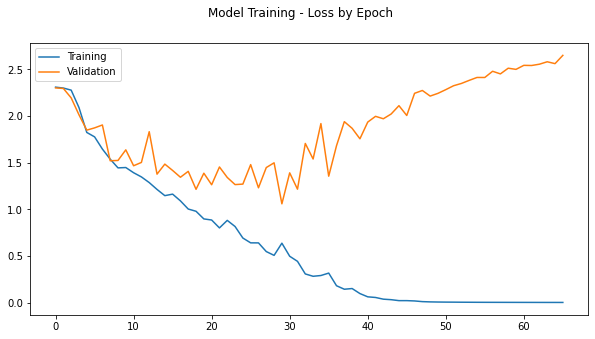

In [122]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(range(len(hist.history['loss'])), hist.history['loss'], label='Training')
plt.plot(range(len(hist.history['val_loss'])), hist.history['val_loss'], label='Validation')
plt.suptitle('Model Training - Loss by Epoch')
plt.legend()
plt.show()

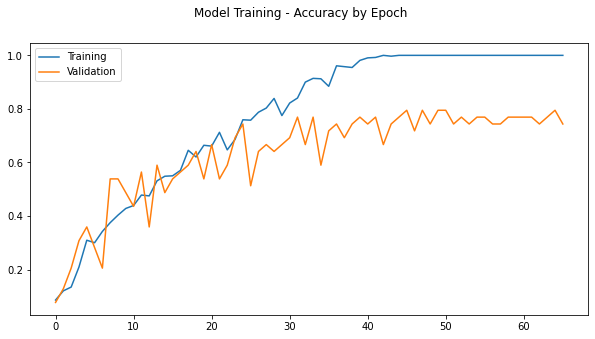

In [123]:
plt.figure(figsize=(10,5))
plt.plot(range(len(hist.history['acc'])), hist.history['acc'], label='Training')
plt.plot(range(len(hist.history['val_acc'])), hist.history['val_acc'], label='Validation')
plt.suptitle('Model Training - Accuracy by Epoch')
plt.legend()
plt.show()

In [126]:
test_img = np.array(Image.open('data/test_img.png').resize((1024,128)))
test_img = test_img * 1./255
test_img = test_img.reshape(1, 128, 1024, 1)
prediction = model.predict(test_img)

In [127]:
prediction.round(2)

array([[0.  , 0.  , 0.  , 0.03, 0.  , 0.  , 0.  , 0.96, 0.01, 0.  ]],
      dtype=float32)